In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from scipy import stats


In [2]:
combined_df = pd.read_csv('../data/unified_percipitation_data.csv')

In [3]:
#removing missing years
combined_df = combined_df[(combined_df['year'] != 1996) & (combined_df['year'] != 1995)]

### Modelling

In [4]:
def prepare_time_series_data(data, look_back=12):
    """
    Create sequences of monthly rainfall data
    look_back: number of previous months to use for prediction
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_data[i + look_back])
    
    return np.array(X), np.array(y), scaler

In [5]:
def create_lstm_model(look_back):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
monthly_rain = combined_df.groupby(['year', 'month'])['precipitation'].mean().values

In [7]:
len(monthly_rain)

60

In [8]:
look_back = 12  # Use 12 months of data to predict next month
train_size = int(len(monthly_rain) * 0.7)

In [9]:
int(len(monthly_rain) * 0.7)

42

In [10]:
X, y, scaler = prepare_time_series_data(monthly_rain, look_back)

In [11]:
# Split into train and test sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
model = create_lstm_model(look_back)

/Users/luses/.local/share/mise/installs/python/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.4523 - val_loss: 0.4744
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3872 - val_loss: 0.4458
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3948 - val_loss: 0.4142
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3314 - val_loss: 0.3783
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3102 - val_loss: 0.3373
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2615 - val_loss: 0.2870
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2171 - val_loss: 0.2240
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1669 - val_loss: 0.1525
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1045 - val_loss: 0.0922
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0733 - val_loss: 0.1038
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1140 - val_loss: 0.1232
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1383 - val_l

In [15]:
train_predict = model.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [16]:
test_predict = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [17]:
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

In [18]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 3.61
Test RMSE: 4.64


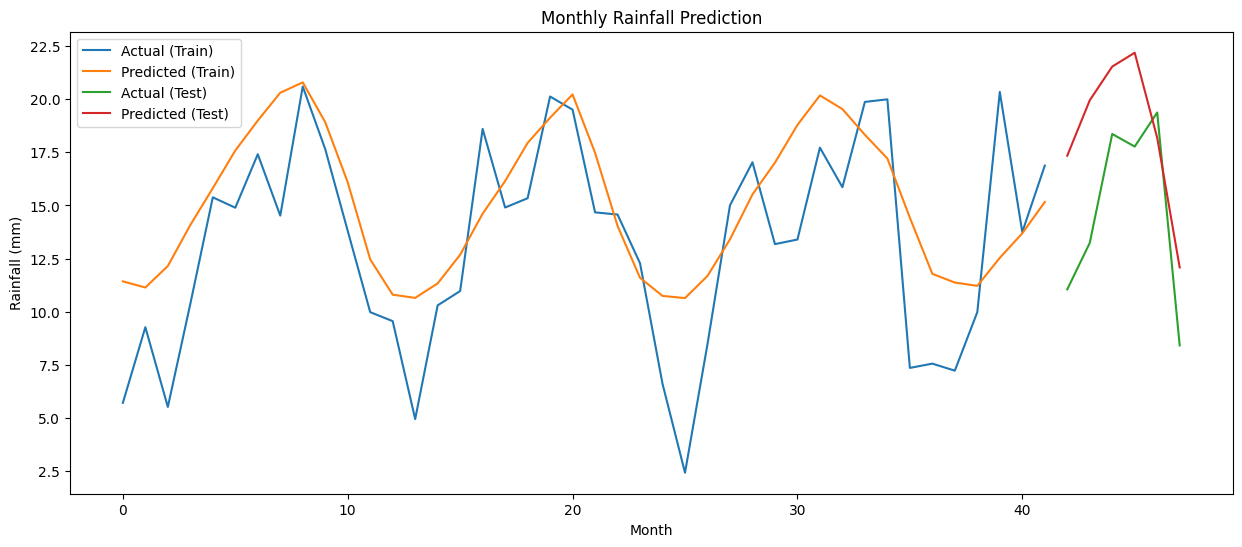

In [19]:
# 7. Visualize results
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(y_train_inv, label='Actual (Train)')
plt.plot(train_predict, label='Predicted (Train)')

plt.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), 
         y_test_inv, label='Actual (Test)')
plt.plot(range(len(y_train_inv), len(y_train_inv) + len(test_predict)), 
         test_predict, label='Predicted (Test)')

plt.title('Monthly Rainfall Prediction')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


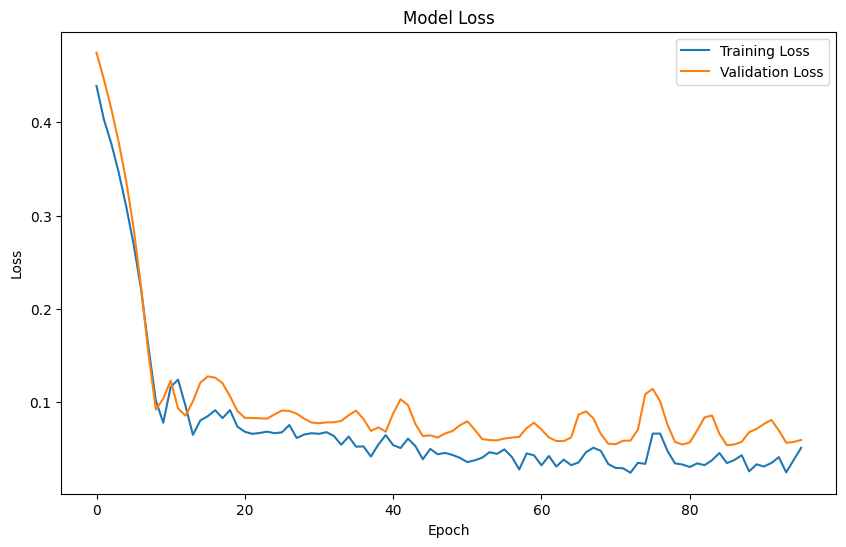

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make predictions

In [21]:
def predict_next_month(model, last_sequence, scaler):
    """
    Predict rainfall for the next month
    last_sequence: last known sequence of rainfall data
    """
    # Scale the input sequence
    scaled_sequence = scaler.transform(last_sequence.reshape(-1, 1))
    # Reshape for LSTM input
    X_input = scaled_sequence.reshape(1, look_back, 1)
    # Make prediction
    predicted_scaled = model.predict(X_input)
    # Inverse transform to get actual rainfall value
    predicted_value = scaler.inverse_transform(predicted_scaled)
    
    return predicted_value[0][0]

In [22]:
monthly_rain = combined_df.groupby(['year', 'month'])['precipitation'].mean().reset_index()
# Create a proper datetime index
monthly_rain['date'] = pd.to_datetime(monthly_rain[['year', 'month']].assign(day=1))
monthly_rain = monthly_rain.set_index('date')['precipitation']

In [23]:
print(f"Data range: {monthly_rain.index.min()} to {monthly_rain.index.max()}")

Data range: 1991-01-01 00:00:00 to 1997-12-01 00:00:00


In [24]:
last_12_months = monthly_rain[-12:].values


In [25]:
print("\nNote: Prediction is based on available historical data up to", monthly_rain.index.max())



Note: Prediction is based on available historical data up to 1997-12-01 00:00:00


In [26]:
next_month_prediction = predict_next_month(model, last_12_months, scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [27]:
april_stats = combined_df[combined_df['month'] == 4]['precipitation'].describe()

In [28]:
print("\nPrediction for April 2025:")
print(f"Predicted rainfall: {next_month_prediction:.2f} mm")
print("\nHistorical April Statistics:")
print(f"Average April rainfall: {april_stats['mean']:.2f} mm")
print(f"Minimum April rainfall: {april_stats['min']:.2f} mm")
print(f"Maximum April rainfall: {april_stats['max']:.2f} mm")



Prediction for April 2025:
Predicted rainfall: 11.40 mm

Historical April Statistics:
Average April rainfall: 13.95 mm
Minimum April rainfall: 0.10 mm
Maximum April rainfall: 154.00 mm


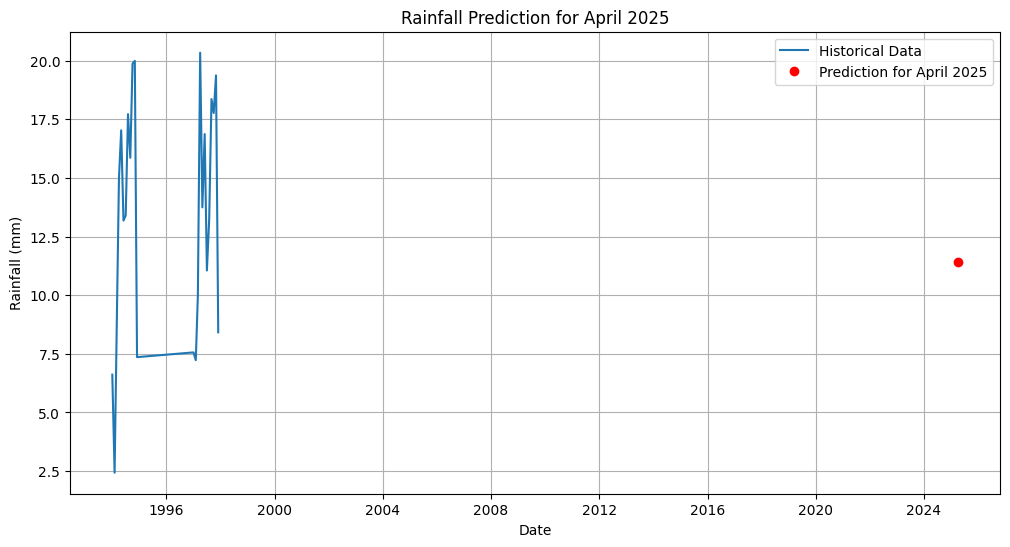

In [29]:
plt.figure(figsize=(12, 6))
recent_months = monthly_rain[-24:]  # Last 24 months for context
plt.plot(recent_months.index, recent_months.values, label='Historical Data')
plt.plot(pd.to_datetime('2025-04-01'), next_month_prediction, 'ro', label='Prediction for April 2025')

plt.title('Rainfall Prediction for April 2025')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
def calculate_prediction_interval(model, last_sequence, scaler, n_iterations=100):
    predictions = []
    for _ in range(n_iterations):
        # Add small random noise to the sequence
        noisy_sequence = last_12_months + np.random.normal(0, 0.1, size=last_12_months.shape)
        pred = predict_next_month(model, noisy_sequence, scaler)
        predictions.append(pred)
    
    # Calculate 95% confidence interval
    ci_lower = np.percentile(predictions, 2.5)
    ci_upper = np.percentile(predictions, 97.5)
    
    return ci_lower, ci_upper

In [31]:
ci_lower, ci_upper = calculate_prediction_interval(model, last_12_months, scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [32]:
print("\nPrediction Interval for April 2025:")
print(f"95% Confidence Interval: {ci_lower:.2f} mm to {ci_upper:.2f} mm")


Prediction Interval for April 2025:
95% Confidence Interval: 11.34 mm to 11.51 mm


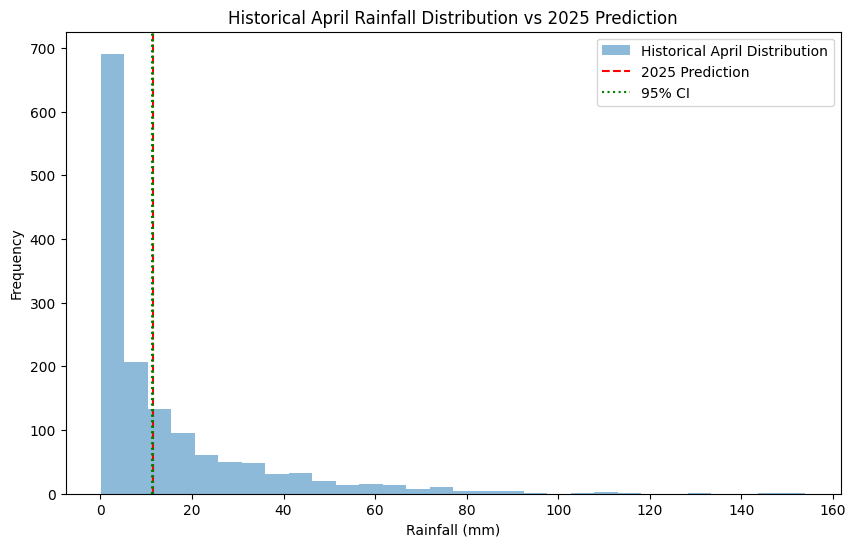

In [33]:
april_data = combined_df[combined_df['month'] == 4]['precipitation']
plt.figure(figsize=(10, 6))
plt.hist(april_data, bins=30, alpha=0.5, label='Historical April Distribution')
plt.axvline(next_month_prediction, color='r', linestyle='--', label='2025 Prediction')
plt.axvline(ci_lower, color='g', linestyle=':', label='95% CI')
plt.axvline(ci_upper, color='g', linestyle=':')
plt.title('Historical April Rainfall Distribution vs 2025 Prediction')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Improve modelling with seasonality and some feature engineering

In [34]:
def analyze_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f'MSE: {mse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.2f}%')
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(y_true - y_pred, bins=30)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (mm)')
    plt.ylabel('Frequency')
    plt.show()


### Save the model

In [35]:
import joblib
import json
from pathlib import Path

# Create a directory for our model artifacts
Path("../models").mkdir(exist_ok=True)

# Save the LSTM model
model.save('../models/rainfall_lstm_model.keras')

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')

# Save model metadata (like look_back period and other parameters)
model_metadata = {
    'look_back': look_back,
    'last_training_date': monthly_rain.index.max().strftime('%Y-%m-%d'),
    'input_features': ['precipitation'],
}
with open('../models/metadata.json', 'w') as f:
    json.dump(model_metadata, f)